Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

In [3]:
import scipy.io
import mat73
import glob 
import datetime

def plot_eddies(eddies, ax):
    
    for eddy in range(np.shape(np.array(eddies['Anticyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Anticyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Anticyclonic_Cell'][eddy][5]

        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3)
       
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3, label='Anticyclonic cell')
        
#         eddy_in_lon = eddies['Anticyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Anticyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='r', ls='--', lw=1)
        
    for eddy in range(np.shape(np.array(eddies['Cyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Cyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Cyclonic_Cell'][eddy][5]
    
        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3)
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3, label='Cyclonic cell')   
    
#         eddy_in_lon = eddies['Cyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Cyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='b', ls='--', lw=1)



import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.5, linestyle='--',color='w',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


Load datasets

In [4]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')
coloc4=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc4.csv')

ERA5_ostia_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_rec.csv').to_xarray() #reconstructed terms ERA5 w ostia sst
ERA5_bulk_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_rec.csv').to_xarray() #reconstructed terms ERA5
ERA5_skin_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_rec.csv').to_xarray() #reconstructed terms ERA5
SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv').to_xarray() #reconstructed terms SD

ERA5_ostia_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_ASFC.csv') #ASFC output ERA5 (coloc3) w ostia sst
ERA5_skin_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_ASFC.csv') #ASFC output ERA5 w skin sst(coloc3)
ERA5_bulk_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_ASFC.csv') #ASFC output ERA5 w bulk sst(coloc3)

SD_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_ASFC.csv') #ASFC output SD

In [5]:
ERA5div=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5div.nc')
msk=(ERA5div.time>=ERA5big.time.min() )& (ERA5div.time<=ERA5big.time.max())

ERA5div=ERA5div.sel(time=msk)

files = sorted(glob.glob(os.getcwd()+'/../MTmichaela/MasterH23/eddies/adt*.mat'))

eddy_files = files

In [6]:
eddies=[]
for fname in tqdm(eddy_files):
    
    # load eddy file for the day
    
    eddies.append(mat73.loadmat(fname))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:34<00:00,  2.02it/s]


* cut off timeframe and make averages? Correlate divergence to Q' ?

In [7]:
def plot_upscale_div(time, vmin, vmax, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=0, abs_div=0, figsize=[29,12]):
    
    fig, ax=plt.subplots(1,1, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    if abs_div ==1:
        cbar_l=ax.pcolormesh(ERA5div.longitude, ERA5div.latitude, np.abs(ERA5div.d.isel(time=time) ), vmin=vmin, vmax=vmax, cmap=cmap )
    else:
        cbar_l=ax.pcolormesh(ERA5div.longitude, ERA5div.latitude, (ERA5div.d.isel(time=time) ), vmin=vmin, vmax=vmax, cmap=cmap )
    
#    cax = ax.inset_axes([0, -0.3, 0.9, 0.1])
#    cbar=fig.colorbar(cbar_l, cax=cax, label=('Divergence [s$^{-1}$] '), orientation='horizontal')
    
#    cbar.ax.tick_params(labelsize=20)
    
    
    plt.colorbar(cbar_l, ax=ax, label='Divergence [s$^{-1}$] ')#, orientation='horizontal')
    
    
#    ax.set_title('Divergence')
   
    alpha=0.4
    
    ax.grid(alpha=alpha)
   
    
    
    ax.set_xlabel('Longitude [°E]')
    
    ax.set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['A','B','C','D'],['E','F','G','H']]
    
    x=0.018
    y=1.05
    
    ax.annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
#    ToF_bottom1=[False, False, False, False]
#    ToF_left1=[True, False, False, False]
    
    ToF_bottom=True #[True, True, True, True]
    ToF_left=True #[True, False, False, False]
    
    # Add land and coastline
 
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

    ax.scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
    ax.scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    for k,spine in ax.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax,10,5, ToF_bottom, ToF_left)
    
    
    
    ax.annotate((pd.to_datetime(ERA5div.time[time].values).strftime("%m/%d/%Y, %H:%M")), xy=(0.10, 1.075), xycoords='axes fraction', bbox=bbox,fontsize=25)
    
    
    ax.set_xlim(ERA5div.longitude.min(),ERA5div.longitude.max())
    ax.set_ylim(ERA5div.latitude.min(),ERA5div.latitude.max())       
    
    #EDDIES
    
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == ERA5div.time[time].values.astype('datetime64[D]'):
                plot_eddies(eddies[i], ax)

                break

                
    ax.legend(loc='lower left',bbox_to_anchor=[0.45,1.01],ncols=2, fontsize='small')

    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/div_fig/pic_{time:04}.png')
    else:
        plt.show()
        
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()

    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [8]:
time=300
vmin=0 #
vmax=0.000175


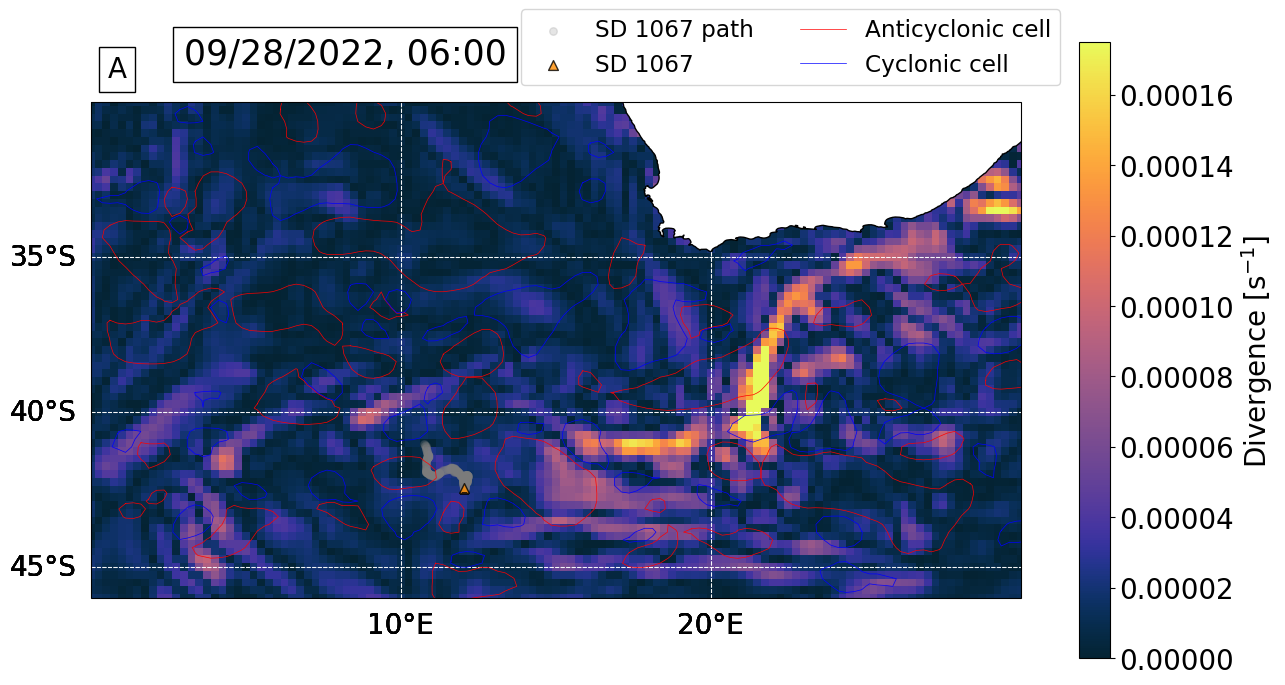

In [9]:
plot_upscale_div(time, vmin, vmax, cmap=cmo.cm.thermal,bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=0, abs_div=1, figsize=[15,8])

In [27]:
for time in tqdm(np.arange(0, len(ERA5div.time))):
    plot_upscale_div(time, vmin, vmax, cmap=cmo.cm.thermal, bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, abs_div=1, figsize=[15,8])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [12:27<00:00,  2.19it/s]


In [28]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/div_fig'
fps=8

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('div.mp4')

Moviepy - Building video div.mp4.
Moviepy - Writing video div.mp4



Moviepy - Done !
Moviepy - video ready div.mp4


In [10]:
rec_ds_ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')

In [11]:
#s_terms=['t_term', 'u_term_t', 'cov_term_t']
#l_terms=['q_term', 'u_term_q', 'cov_term_q']

rec_div_r2=ERA5big.copy().drop(['u10','v10','d2m','t2m','P_SEA','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs','skt']).drop('time')
arr= np.ndarray((65,121))*np.nan

rec_div_r2['d_s']=xr.DataArray(arr.copy(),dims=('latitude','longitude'))
rec_div_r2['d_l']=xr.DataArray(arr.copy(),dims=('latitude','longitude'))


In [12]:
for lat in tqdm(np.arange(len(rec_ds_ERA5.latitude))):
    
    for lon in np.arange(len(rec_ds_ERA5.longitude)):
        rec=rec_ds_ERA5.isel(latitude=lat, longitude=lon)
        div=ERA5div.isel(latitude=lat, longitude=lon)

        msk2=np.isfinite(rec.shf_fluc)
        msk=np.isfinite(div.d)
        
  
        div_np=div['d'].sel(time=msk2 & msk)
        rec_shf=rec.shf_fluc.sel(time=msk2 & msk)
        rec_lhf=rec.lhf_fluc.sel(time=msk2 & msk)

#        msk=np.isfinite(ERA5div['d'])
        rec_div_r2['d_s'][lat,lon]=scipy.stats.linregress(rec_shf, div_np).rvalue**2
        rec_div_r2['d_l'][lat,lon]=scipy.stats.linregress(rec_lhf, div_np).rvalue**2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [04:10<00:00,  3.85s/it]


In [ ]:
#S=S1.copy().values
#plume1=plume[:,:,:].copy().values

#for n in tqdm(np.arange(0,len(plume.time)-1)): #time

#    for i in np.arange(1,len(plume.x)-1): #x
#        for j in np.arange(1, len(plume.z)-1): #z
            
#            new=(S[j,i]
#                +D[j]*((plume1[j,i-1,n]-2*plume1[j,i,n]+plume1[j,i+1,n])/dx**2) #diffusion x-direction
#            +D[j]*((plume1[j-1,i,n]-2*plume1[j,i,n]+plume1[j+1,i,n])/dz**2) #diffusion z-direction
#            -U[j]*(-plume1[j,i-1,n]+plume1[j,i,n])/dx) #advection in x with upstream wind
          #  -W[i]*(-plume1[j-1,i,n]+plume1[j,i,n])/dz) #Advection in z, just to test, not successful
             #Source added here #source already added in plume array to avoid a extra step in for-loop
           
#            plume1[j,i,n+1]=plume1[j,i,n]+new*dt #add new values times dt to next timestep 
            #print(plume[j,i,n].values)   

In [117]:
rec_div_r2.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2_div.nc')

In [ ]:
rec_div_r2=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2_div.nc')

In [26]:
def plot_upscale_div_r2(vmin, vmax, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), figsize=[29,12]):
    
    fig, ax=plt.subplots(1,2, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)

    ax[0].pcolormesh(ERA5div.longitude, ERA5div.latitude, (rec_div_r2.d_l ), vmin=vmin, vmax=vmax, cmap=cmap )
    cbar_l=ax[1].pcolormesh(ERA5div.longitude, ERA5div.latitude, (rec_div_r2.d_s ), vmin=vmin, vmax=vmax, cmap=cmap )
    
#    cax = ax[0][0].inset_axes([0, -0.3, 0.9, 0.1])
#    cbar=fig.colorbar(cbar_l, cax=cax, label=('Divergence [s$^{-1}$] '), orientation='horizontal')
    
#    cbar.ax[0].tick_params(labelsize=20)
    
    
    plt.colorbar(cbar_l, ax=ax[1], label='R$^2$')#, orientation='horizontal')
    
    
#    ax[0].set_title('Divergence')
   
    alpha=0.4
    
    ax[0].grid(alpha=alpha)
    ax[1].grid(alpha=alpha)
    
    
    ax[0].set_xlabel('Longitude [°E]')
    
    ax[0].set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['A','B','C','D'],['E','F','G','H']]
    
    x=0.018
    y=1.05
    
    ax[0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#    ToF_bottom1=[False, False, False, False]
#    ToF_left1=[True, False, False, False]
    
    ToF_bottom=True #[True, True, True, True]
    ToF_left=True #[True, False, False, False]
    
    # Add land and coastline
 
    ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

    
    ax[0].scatter(dsadcpH.longitude, dsadcpH.latitude, s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    ax[1].scatter(dsadcpH.longitude, dsadcpH.latitude, s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')    
    
    for k,spine in ax[0].spines.items():  #ax[0].spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[0],10,5, ToF_bottom, ToF_left)
        
    for k,spine in ax[1].spines.items():  #ax[0].spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[1],10,5, ToF_bottom, ToF_left)
    

    
    ax[0].set_xlim(ERA5div.longitude.min(),ERA5div.longitude.max())
    ax[0].set_ylim(ERA5div.latitude.min(),ERA5div.latitude.max())       
    ax[0].set_title('Div corr with LHF`')
    ax[1].set_title('Div corr with SHF`')

                
#    ax[0].legend(loc='lower left',bbox_to_anchor=[0.45,1.01],ncols=2, fontsize='small')
        
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()
#ax[0][1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

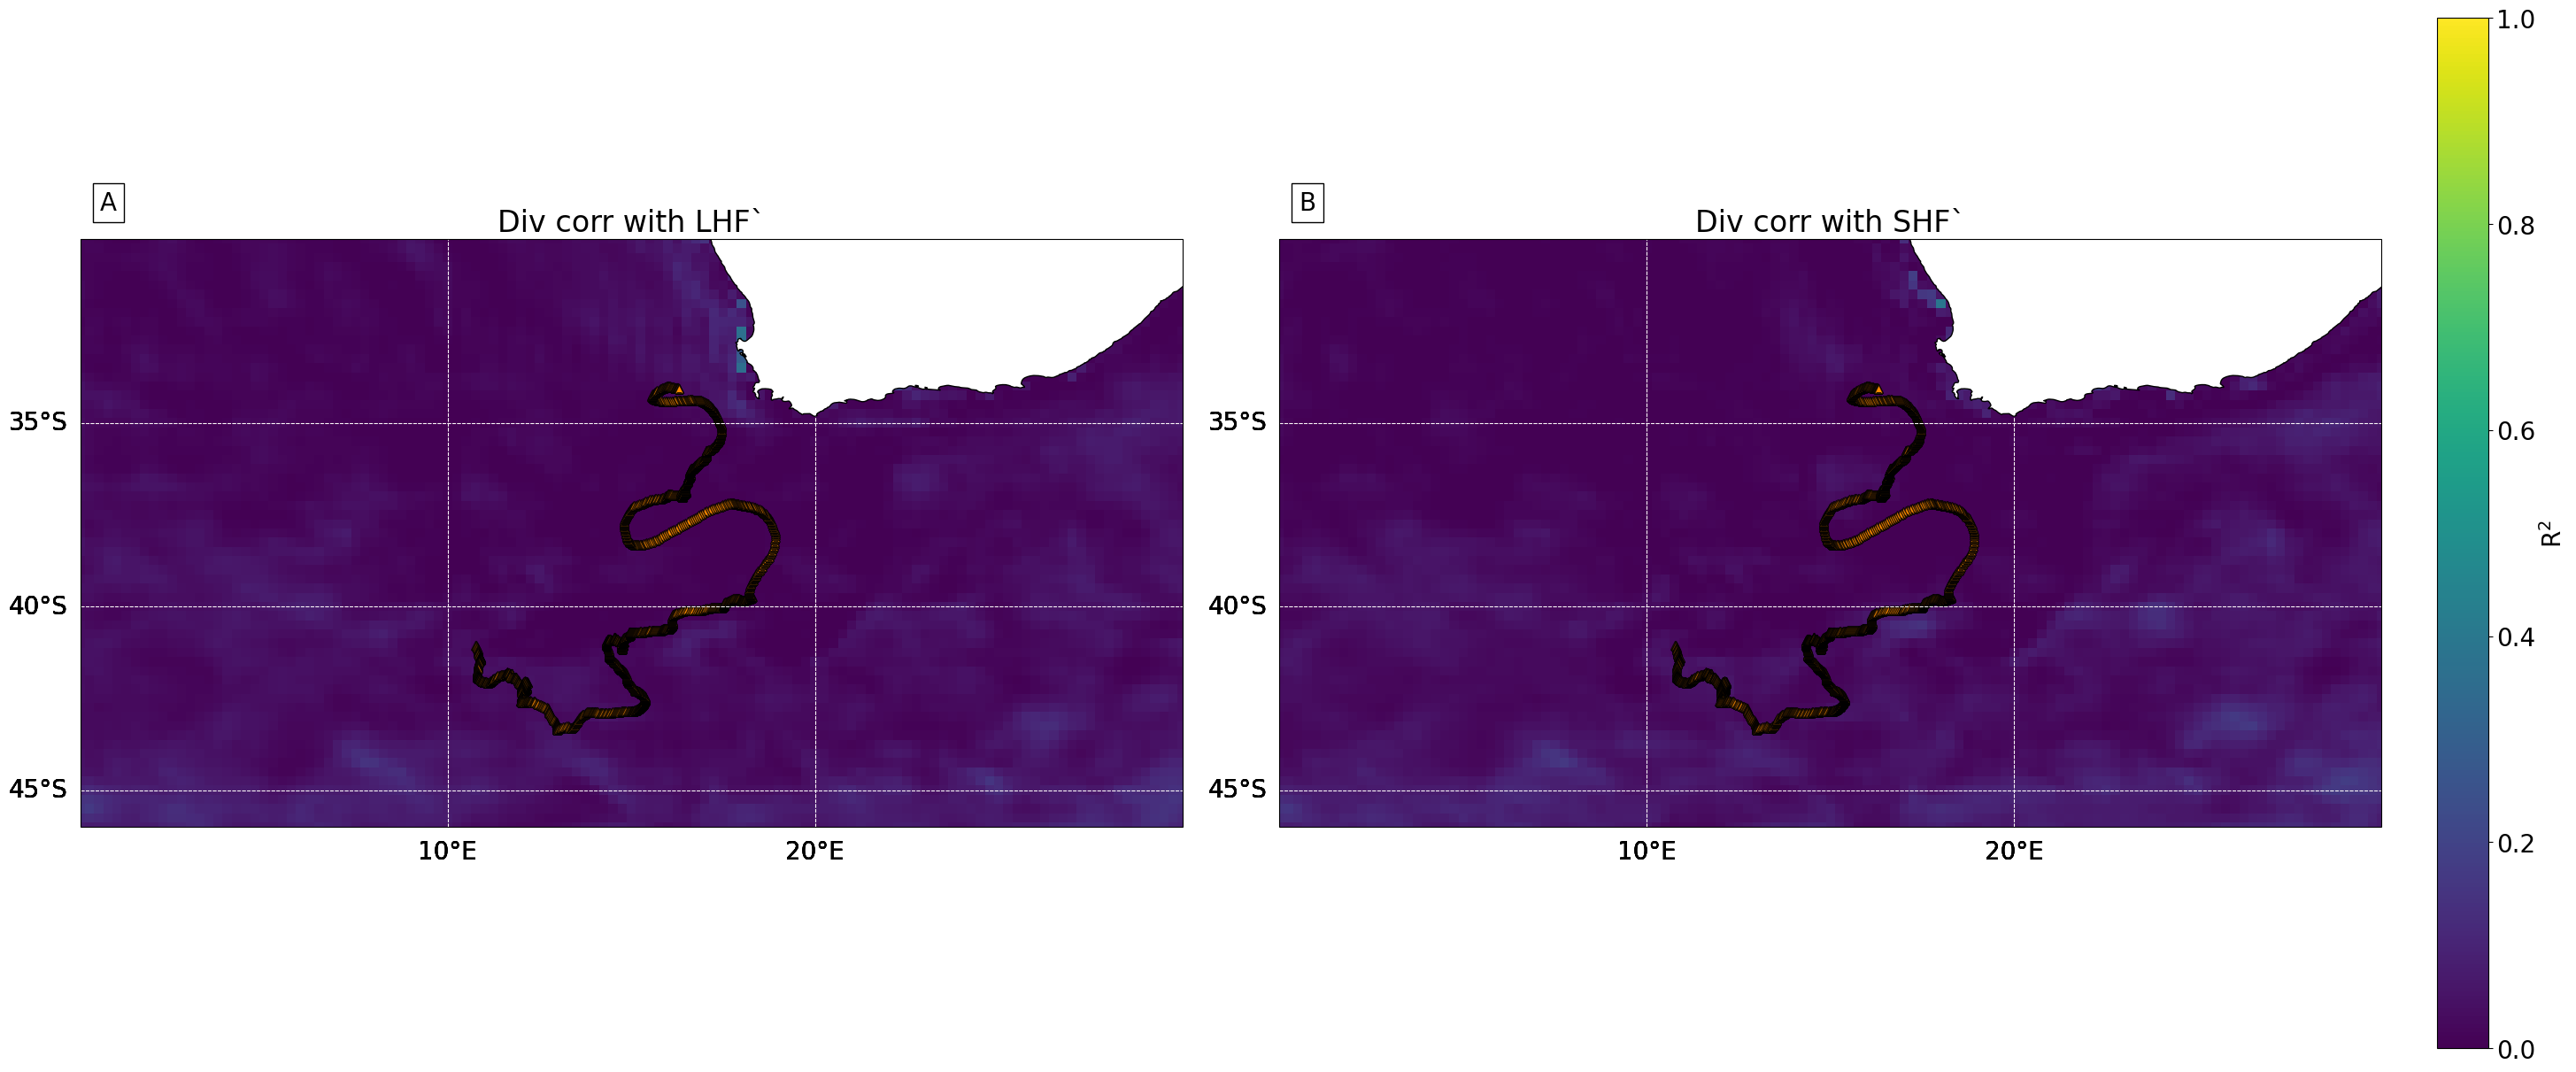

In [28]:
plot_upscale_div_r2(0, 1, cmap=None,bbox = dict(boxstyle="square", fc='w'), figsize=[29,12])